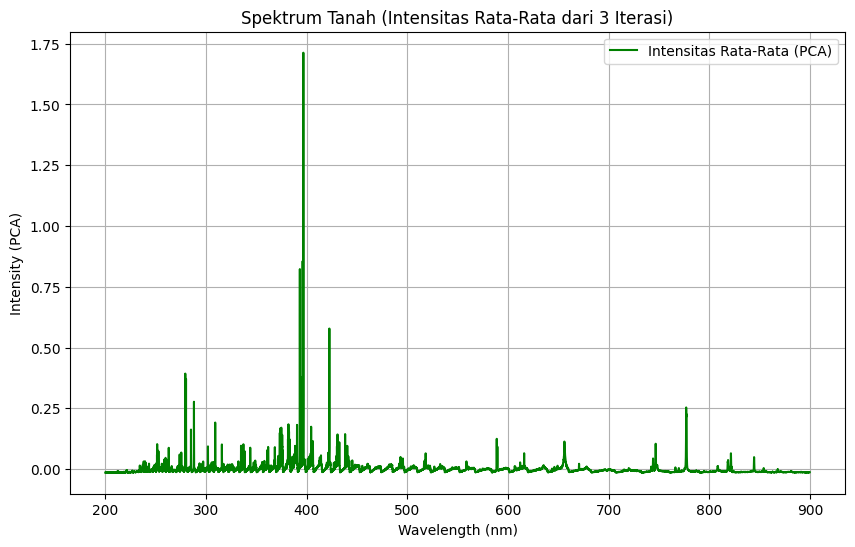

In [11]:
import sqlite3
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Fungsi untuk mengambil spektrum dari database
def spec(db_path, sample_name, iteration, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Query dasar untuk mendapatkan data spektrum
    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
    """
    
    params = [sample_name, iteration]

    # Tambahkan kondisi untuk panjang gelombang jika ada
    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])
    elif lower_bound is not None:
        query += " AND wavelength >= ?"
        params.append(lower_bound)
    elif upper_bound is not None:
        query += " AND wavelength <= ?"
        params.append(upper_bound)

    query += " ORDER BY wavelength"

    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data ditemukan untuk sampel: {sample_name}, iterasi: {iteration}")
        return np.array([]), np.array([])

    wavelengths, intensities = zip(*data)

    return np.array(wavelengths), np.array(intensities)

# Contoh pemanggilan untuk tiga iterasi dari satu sampel
db_path = 'tanah_vulkanik.db'
sample_name = 'S3'
wavelengths_iter1, intensities_iter1 = spec(db_path, sample_name, iteration=1, lower_bound=200, upper_bound=900)
wavelengths_iter2, intensities_iter2 = spec(db_path, sample_name, iteration=2, lower_bound=200, upper_bound=900)
wavelengths_iter3, intensities_iter3 = spec(db_path, sample_name, iteration=3, lower_bound=200, upper_bound=900)

# Pastikan panjang gelombang dari ketiga iterasi sama sebelum melanjutkan
assert np.array_equal(wavelengths_iter1, wavelengths_iter2) and np.array_equal(wavelengths_iter2, wavelengths_iter3), "Panjang gelombang tidak cocok antar iterasi!"

# Gabungkan intensitas dari ketiga iterasi menjadi satu matriks
intensities_matrix = np.vstack([intensities_iter1, intensities_iter2, intensities_iter3]).T

# Normalisasi intensitas menggunakan MinMaxScaler
scaler = MinMaxScaler()
intensities_matrix_normalized = scaler.fit_transform(intensities_matrix)

# Terapkan PCA pada intensitas yang dinormalisasi
pca = PCA(n_components=1)
intensities_pca = pca.fit_transform(intensities_matrix_normalized)

# Hasil komponen utama pertama dari PCA akan digunakan sebagai intensitas rata-rata
intensitas_rata_rata = intensities_pca[:, 0]
# Visualisasi hasil intensitas rata-rata yang diperoleh dari PCA
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(wavelengths_iter1, intensitas_rata_rata, label='Intensitas Rata-Rata (PCA)', color='green')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (PCA)')
plt.title('Spektrum Tanah (Intensitas Rata-Rata dari 3 Iterasi)')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Normalisasi dataset unsur murni dan dataset tanah
data_unsur_murni['intensity'] = scaler.fit_transform(data_unsur_murni[['intensity']])
data_tanah['intensity'] = scaler.transform(data_tanah[['intensity']])

NameError: name 'data_unsur_murni' is not defined

In [2]:
def filter_wavelength_range(df, min_wl=200, max_wl=900):
    return df[(df['wavelength'] >= min_wl) & (df['wavelength'] <= max_wl)]

data_unsur_murni = filter_wavelength_range(data_unsur_murni)
data_tanah = filter_wavelength_range(data_tanah)

NameError: name 'data_unsur_murni' is not defined

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)  # Misalnya, menggunakan 5 cluster
clusters_tanah = kmeans.fit_predict(data_tanah[['wavelength', 'intensity']])

In [ ]:
from scipy.signal import correlate

# Hitung korelasi silang antara spektrum tanah dan spektrum unsur murni
correlation_cu = correlate(data_tanah['intensity'], data_cu['intensity'])
correlation_fe = correlate(data_tanah['intensity'], data_fe['intensity'])

print("Max correlation Cu:", np.max(correlation_cu))
print("Max correlation Fe:", np.max(correlation_fe))

In [ ]:
from sklearn.semi_supervised import LabelSpreading

# Gabungkan data berlabel dan tidak berlabel
X = np.vstack((data_unsur_murni[['wavelength', 'intensity']].values, data_tanah[['wavelength', 'intensity']].values))
labels = np.array(list(data_unsur_murni['element']) + [-1] * len(data_tanah))  # Label -1 untuk data tidak berlabel

# Terapkan Label Spreading
label_spreading = LabelSpreading(kernel='rbf', alpha=0.2)
label_spreading.fit(X, labels)

# Prediksi label untuk data tanah yang tidak berlabel
predicted_labels = label_spreading.predict(data_tanah[['wavelength', 'intensity']].values)

In [ ]:
from sklearn.svm import SVC

X_train = data_tanah[['wavelength', 'intensity']].values
y_train = predicted_labels

svm_rbf = SVC(kernel='rbf', gamma='scale', C=1.0)
svm_rbf.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = svm_rbf.predict(data_uji[['wavelength', 'intensity']].values)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(data_tanah['wavelength'], data_tanah['intensity'], label='Tanah (Eksperimen)')
plt.plot(data_cu['wavelength'], data_cu['intensity'], label='Spektrum Cu', alpha=0.6)
plt.plot(data_fe['wavelength'], data_fe['intensity'], label='Spektrum Fe', alpha=0.6)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity')
plt.legend()
plt.show()